# Chinese Food Life Cycle Assessment

You are part of the sustainability analysis team at GreenPort Imports, a Hamburg-based company specializing in importing food products from around the world. GreenPort prides itself on aligning its imports with sustainability goals, aiming to minimize environmental impacts while meeting consumer demands.

As a data analyst, your role is to evaluate and compare the environmental impacts of different food groups and subgroups using data from the newly developed Chinese Food Life Cycle Assessment Database (CFLCAD). The CFLCAD provides environmental impact data such as Greenhouse Gas Emissions (GHGE), Water Use (WU), and Land Use (LU) for a range of food items and food groups. Your analysis will help the company determine which food groups comply with GreenPort’s sustainability criteria and should therefore be prioritized for import.

* Is there a significant difference in Greenhouse Gas Emissions (GHGE), WU, LU across food groups and/or in food sub-groups?
* Which specific food groups and/or food sub-groups differ significantly in their GHGE, WU, or LU?
* Which food groups and/or food sub-groups are potential candidates for us to import?
* You have five minutes to present your results.

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Get rid of FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the data

In [2]:
# Load the dataset
file_path = 'Chinese Food Life Cycle Assessment Database.xlsx'
xls = pd.ExcelFile(file_path)

# Load each sheet
ghg_df = xls.parse('Greenhouse Gas Emission')
wu_df = xls.parse('Water Use')
lu_df = xls.parse('Land Use')

# Standardize column names for consistency
ghg_df.columns = ghg_df.columns.str.strip().str.replace('\n', '', regex=True)
wu_df.columns = wu_df.columns.str.strip().str.replace('\n', '', regex=True)
lu_df.columns = lu_df.columns.str.strip().str.replace('\n', '', regex=True)

# Standardize 'Food group' column values to lowercase for consistency
ghg_df['Food group'] = ghg_df['Food group'].str.lower()
wu_df['Food group'] = wu_df['Food group'].str.lower()
lu_df['Food group'] = lu_df['Food group'].str.lower()

# Drop 'Data source' and 'Language of journal' columns
ghg_df = ghg_df.drop(columns=['Data source', 'Language of journal'])
wu_df = wu_df.drop(columns=['Data source', 'Language of journal'])
lu_df = lu_df.drop(columns=['Data source', 'Language of journal'])

In [3]:
ghg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Foodcode of Chinese Food Composition Table   2061 non-null   int64  
 1   Food item                                    2061 non-null   object 
 2   Food sub-group                               2061 non-null   object 
 3   Food group                                   2061 non-null   object 
 4   GHGE of 1 kg food as consumed(kg CO2-eq/kg)  2061 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 80.6+ KB


In [4]:
wu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Foodcode of Chinese Food Composition Table  2027 non-null   int64  
 1   Food item                                   2026 non-null   object 
 2   Food sub-group                              2027 non-null   object 
 3   Food group                                  2027 non-null   object 
 4   WU of 1 kg food as consumed (m³/kg)         2027 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 79.3+ KB


In [5]:
lu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Foodcode of Chinese Food Composition Table  882 non-null    int64  
 1   Food item                                   882 non-null    object 
 2   Food sub-group                              882 non-null    object 
 3   Food group                                  882 non-null    object 
 4   LU of 1 kg food as consumed (㎡/kg)          882 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 34.6+ KB


## Check distribution of the data in each datasets

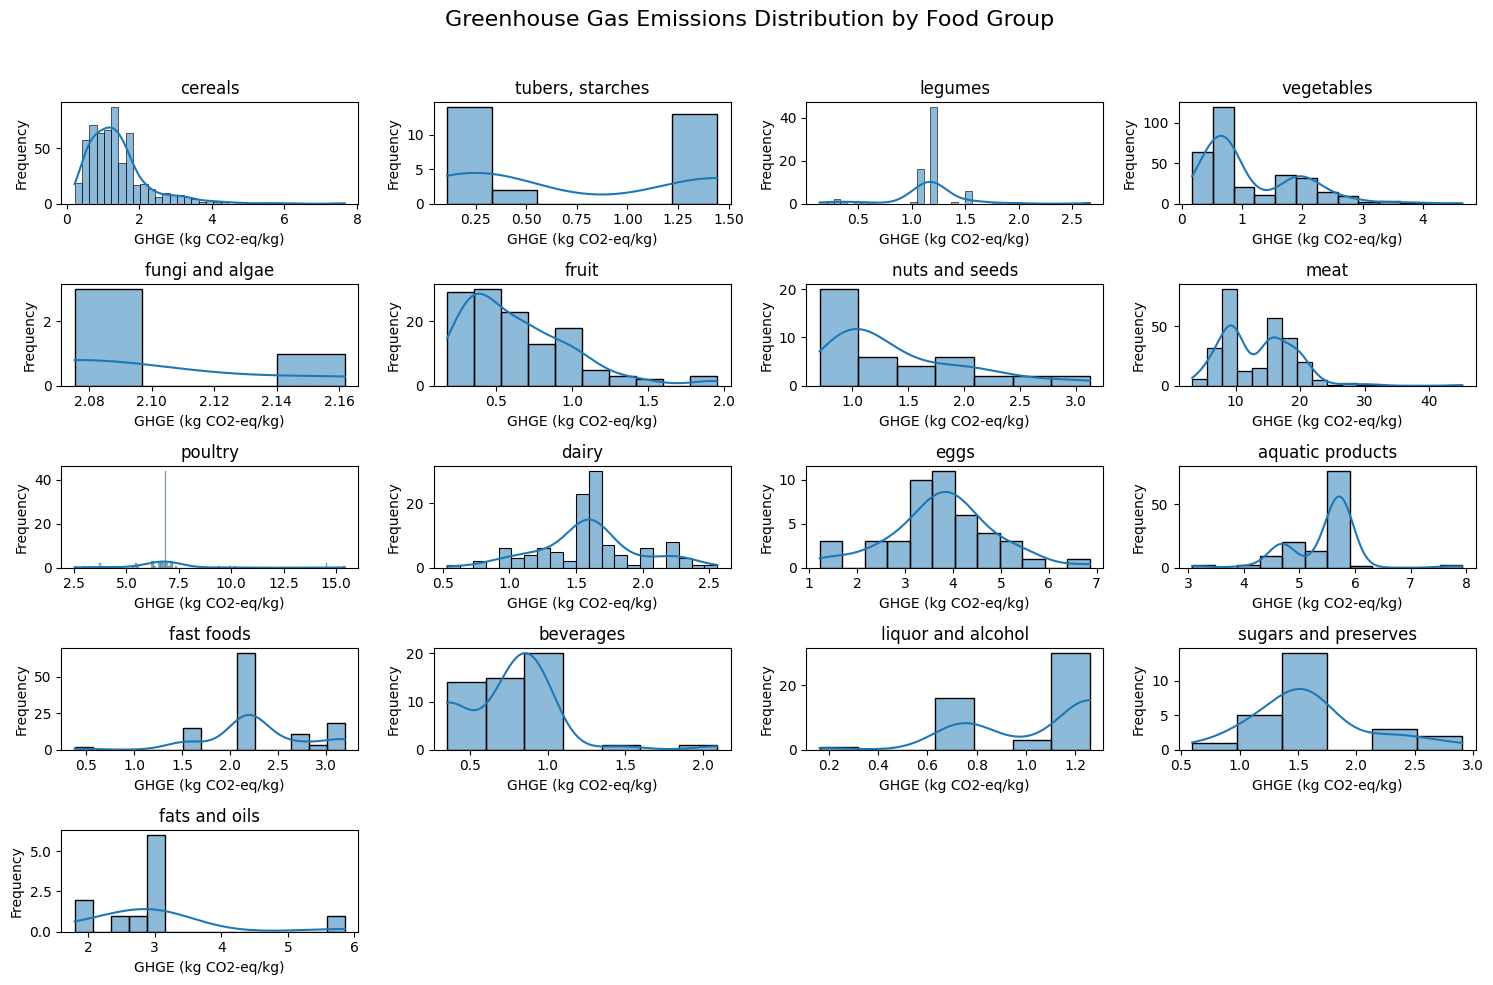

In [6]:
# Generate histograms for each food group in ghg_df
food_groups = ghg_df['Food group'].unique()

plt.figure(figsize=(15, 10))
for i, group in enumerate(food_groups, 1):
    plt.subplot(5, 4, i)
    sns.histplot(ghg_df[ghg_df['Food group'] == group]['GHGE of 1 kg food as consumed(kg CO2-eq/kg)'], kde=True)
    plt.title(group)
    plt.xlabel('GHGE (kg CO2-eq/kg)')
    plt.ylabel('Frequency')

plt.suptitle('Greenhouse Gas Emissions Distribution by Food Group', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

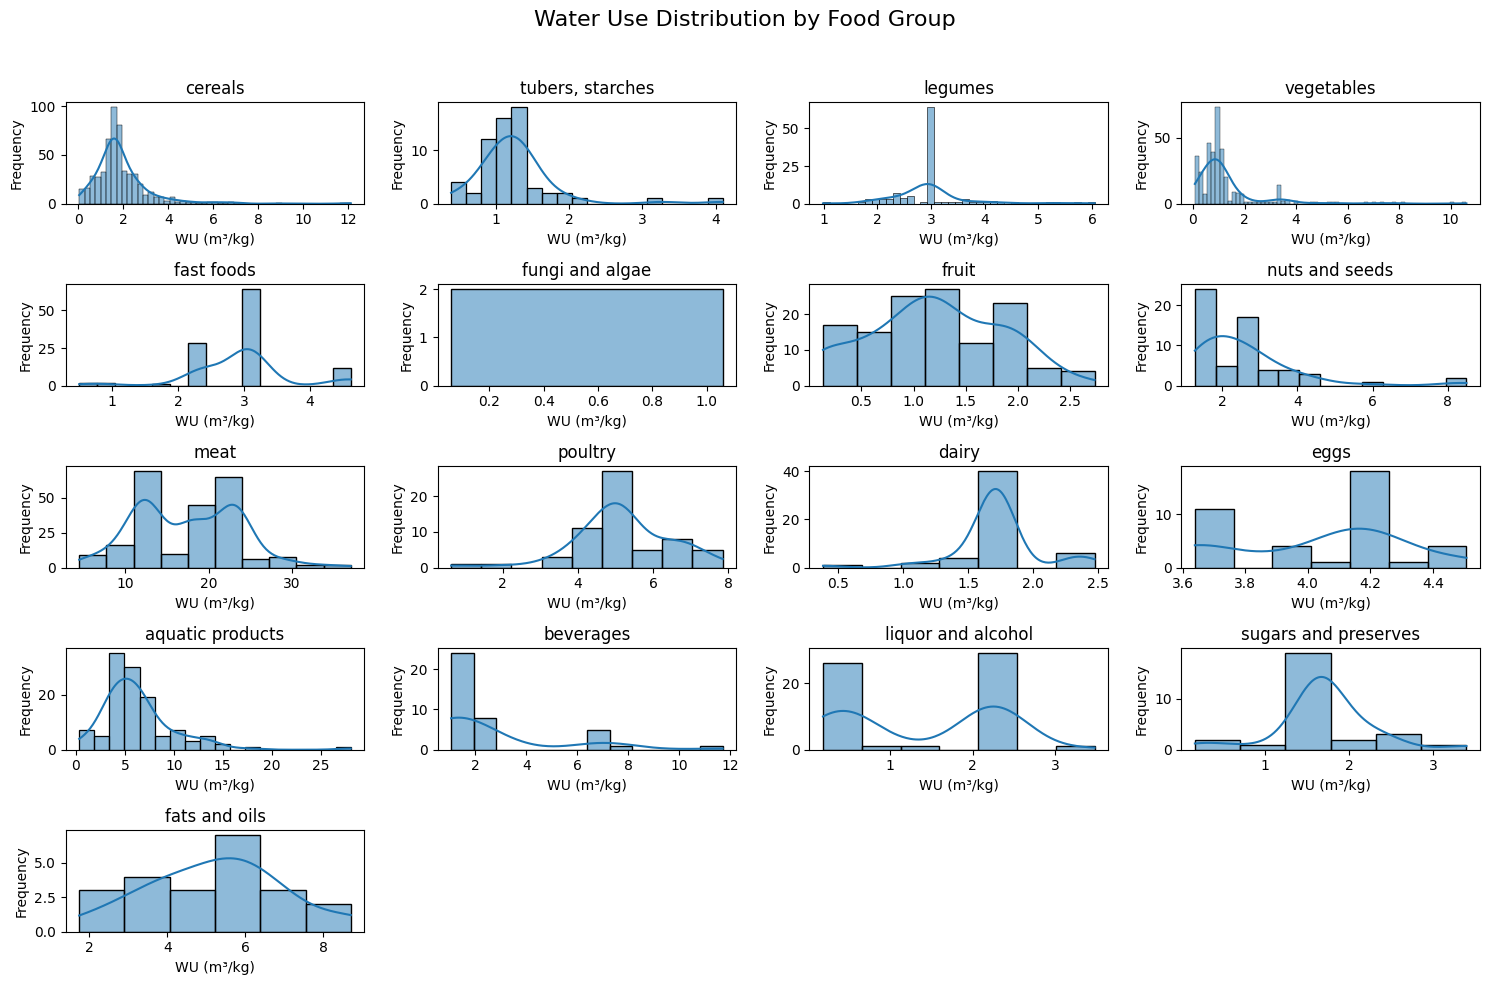

In [7]:
# Generate histograms for each food group in wu_df
food_groups_wu = wu_df['Food group'].unique()

plt.figure(figsize=(15, 10))
for i, group in enumerate(food_groups_wu, 1):
    plt.subplot(5, 4, i)
    sns.histplot(wu_df[wu_df['Food group'] == group]['WU of 1 kg food as consumed (m³/kg)'], kde=True)
    plt.title(group)
    plt.xlabel('WU (m³/kg)')
    plt.ylabel('Frequency')

plt.suptitle('Water Use Distribution by Food Group', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

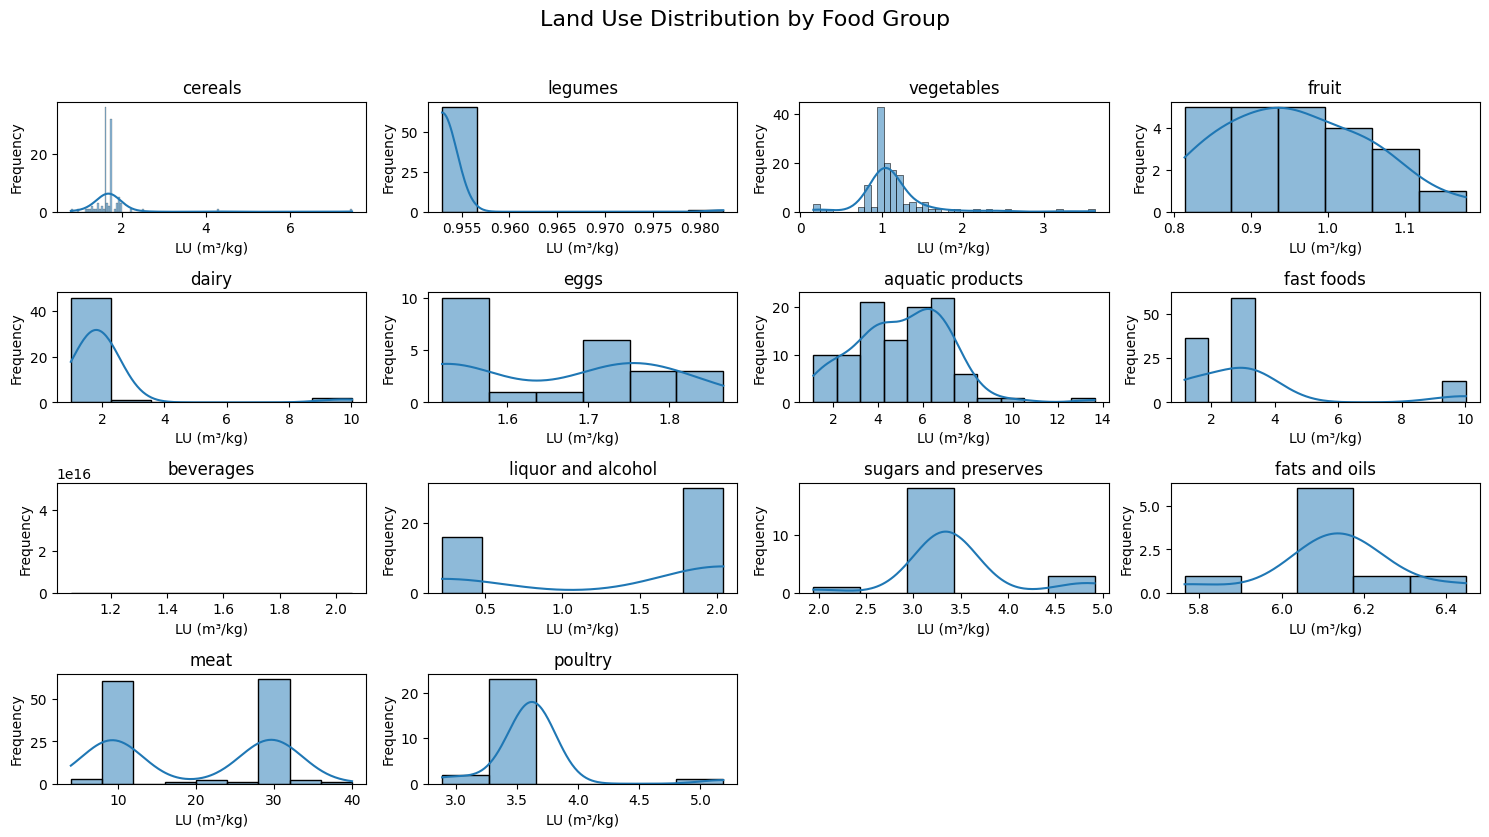

In [8]:
# Generate histograms for each food group in wu_df
food_groups_lu = lu_df['Food group'].unique()

plt.figure(figsize=(15, 10))
for i, group in enumerate(food_groups_lu, 1):
    plt.subplot(5, 4, i)
    sns.histplot(lu_df[lu_df['Food group'] == group]['LU of 1 kg food as consumed (㎡/kg)'], kde=True)
    plt.title(group)
    plt.xlabel('LU (m³/kg)')
    plt.ylabel('Frequency')

plt.suptitle('Land Use Distribution by Food Group', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
# Merge the sheets on common identifying columns
merged_df = pd.merge(
    ghg_df, 
    wu_df[['Foodcode of Chinese Food Composition Table', 'WU of 1 kg food as consumed (m³/kg)']], 
    on='Foodcode of Chinese Food Composition Table', how='inner'
)
merged_df = pd.merge(
    merged_df, 
    lu_df[['Foodcode of Chinese Food Composition Table', 'LU of 1 kg food as consumed (㎡/kg)']], 
    on='Foodcode of Chinese Food Composition Table', how='inner'
)

# Group data by both Food group and Food sub-group and calculate mean GHGE, WU, LU for each combination
grouped_df = merged_df.groupby(['Food group']).agg({
    'GHGE of 1 kg food as consumed(kg CO2-eq/kg)': 'mean',
    'WU of 1 kg food as consumed (m³/kg)': 'mean',
    'LU of 1 kg food as consumed (㎡/kg)': 'mean'
}).reset_index()

# Rename columns for clarity
grouped_df.columns = ['Food group', 'Mean GHGE (kg CO2-eq/kg)', 'Mean WU (m³/kg)', 'Mean LU (㎡/kg)']

# Display results
print("Environmental Impact Means by Food Sub-group:")
display(grouped_df)

Environmental Impact Means by Food Sub-group:


,Food group,Mean GHGE (kg CO2-eq/kg),Mean WU (m³/kg),Mean LU (㎡/kg)
0,aquatic products,5.437855,5.851770,4.971411
1,beverages,0.890392,1.336184,1.557895
2,cereals,1.457515,1.618450,1.749219
3,dairy,1.535481,1.715047,1.928915
4,eggs,3.845798,4.130361,1.724620
5,fast foods,2.448779,3.075237,3.767582
6,fats and oils,2.999492,5.081324,6.129412
7,fruit,0.950083,1.170136,1.053322
8,legumes,0.994773,2.940117,0.952991
9,liquor and alcohol,1.035066,1.519463,1.229135


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499722 entries, 0 to 499721
Data columns (total 7 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Foodcode of Chinese Food Composition Table   499722 non-null  int64  
 1   Food item                                    499722 non-null  object 
 2   Food sub-group                               499722 non-null  object 
 3   Food group                                   499722 non-null  object 
 4   GHGE of 1 kg food as consumed(kg CO2-eq/kg)  499722 non-null  float64
 5   WU of 1 kg food as consumed (m³/kg)          499722 non-null  float64
 6   LU of 1 kg food as consumed (㎡/kg)           499722 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 26.7+ MB


<Figure size 1200x600 with 0 Axes>

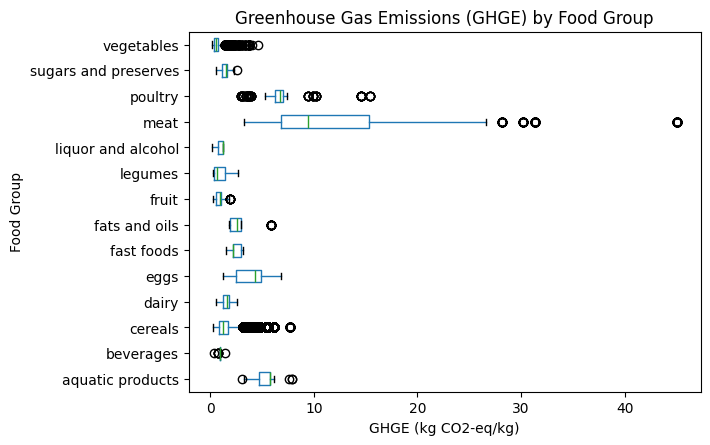

In [11]:
# Boxplot for Greenhouse Gas Emissions (GHGE) by Food group
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='GHGE of 1 kg food as consumed(kg CO2-eq/kg)', by='Food group', grid=False, vert=False)
plt.title('Greenhouse Gas Emissions (GHGE) by Food Group')
plt.suptitle('')  # Removes the automatic boxplot title
plt.xlabel('GHGE (kg CO2-eq/kg)')
plt.ylabel('Food Group')
plt.show()  # Ensures this plot is shown

<Figure size 1200x600 with 0 Axes>

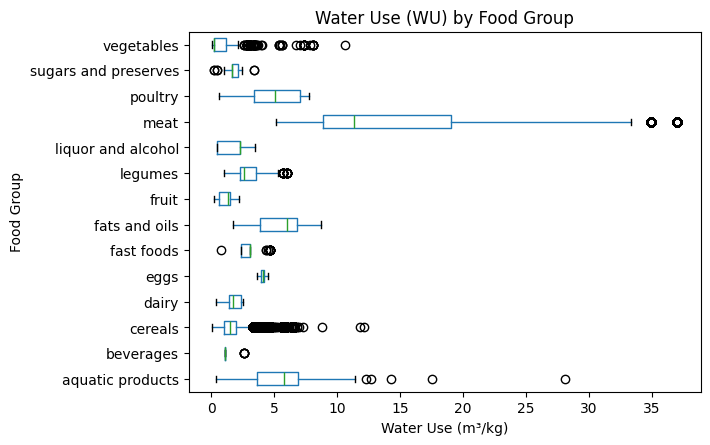

In [17]:
# Boxplot for Water Use (WU) by Food group
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='WU of 1 kg food as consumed (m³/kg)', by='Food group', grid=False, vert=False)
plt.title('Water Use (WU) by Food Group')
plt.suptitle('')  # Removes the automatic boxplot title
plt.xlabel('Water Use (m³/kg)')
plt.ylabel('Food Group')
plt.show()

In [ ]:
# Boxplot for Land Use (LU) by Food group
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='LU of 1 kg food as consumed (m³/kg)', by='Food group', grid=False, vert=False)
plt.title('Water Use (LU) by Food Group')
plt.suptitle('')  # Removes the automatic boxplot title
plt.xlabel('Land Use (m³/kg)')
plt.ylabel('Food Group')
plt.show()

In [14]:
# Group data by both Food group and Food sub-group and calculate mean GHGE, WU, LU for each combination
subgrouped_df = merged_df.groupby(['Food group', 'Food sub-group']).agg({
    'GHGE of 1 kg food as consumed(kg CO2-eq/kg)': 'mean',
    'WU of 1 kg food as consumed (m³/kg)': 'mean',
    'LU of 1 kg food as consumed (㎡/kg)': 'mean'
}).reset_index()

# Rename columns for clarity
subgrouped_df.columns = ['Food group', 'Food sub-group', 'Mean GHGE (kg CO2-eq/kg)', 'Mean WU (m³/kg)', 'Mean LU (㎡/kg)']

# Display results
print("Environmental Impact Means by Food Sub-group:")
display(subgrouped_df)

Environmental Impact Means by Food Sub-group:


,Food group,Food sub-group,Mean GHGE (kg CO2-eq/kg),Mean WU (m³/kg),Mean LU (㎡/kg)
0,aquatic products,fish,5.695955,5.734781,5.965248
1,aquatic products,shellfish,4.597926,9.157509,3.397140
2,aquatic products,shrimp,4.720290,6.088383,2.158073
3,beverages,carbonated drink,0.748538,2.583814,1.557895
4,beverages,fruit juice and drink,0.922632,1.052632,1.557895
5,cereals,corn,1.088821,1.175126,2.154946
6,cereals,rice,1.635702,1.754245,1.678059
7,cereals,wheat,1.331479,1.526063,1.793719
8,dairy,liquid milk,1.535188,1.715047,1.929223
9,dairy,milk powder,1.632516,1.715047,1.826581


/var/folders/rc/94x6p6qj39xgzwckdbdy9qc00000gn/T/ipykernel_37452/1515395126.py:16: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/timursalakhetdinov/Applied Statistical Analysis/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


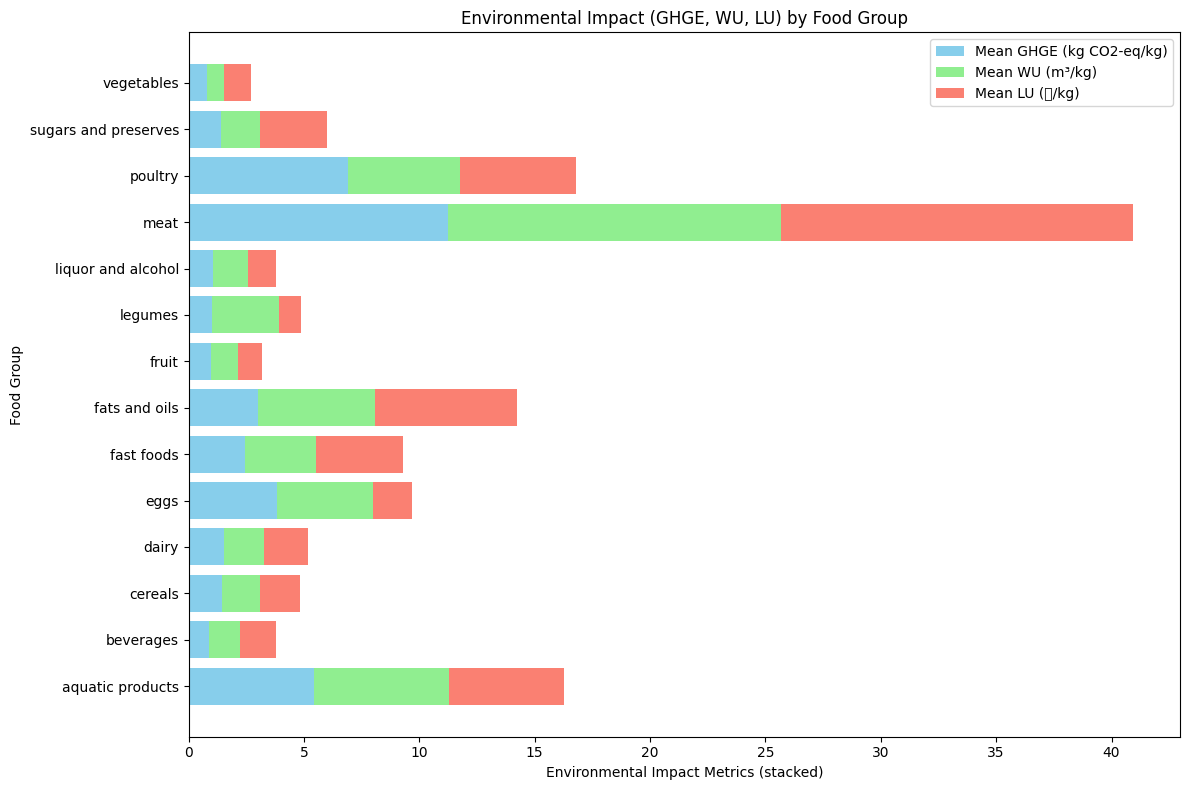

In [15]:
# Plot mean GHGE, WU, and LU for each Food group in a stacked bar chart
plt.figure(figsize=(12, 8))

# Plot each environmental metric as a stacked bar
plt.barh(grouped_df['Food group'], grouped_df['Mean GHGE (kg CO2-eq/kg)'], color='skyblue', label='Mean GHGE (kg CO2-eq/kg)')
plt.barh(grouped_df['Food group'], grouped_df['Mean WU (m³/kg)'], color='lightgreen', label='Mean WU (m³/kg)', 
         left=grouped_df['Mean GHGE (kg CO2-eq/kg)'])
plt.barh(grouped_df['Food group'], grouped_df['Mean LU (㎡/kg)'], color='salmon', label='Mean LU (㎡/kg)', 
         left=(grouped_df['Mean GHGE (kg CO2-eq/kg)'] + grouped_df['Mean WU (m³/kg)']))

# Add labels and title
plt.xlabel("Environmental Impact Metrics (stacked)")
plt.ylabel("Food Group")
plt.title("Environmental Impact (GHGE, WU, LU) by Food Group")
plt.legend(loc='upper right')
plt.tight_layout()

# Show plot
plt.show()

In [16]:
# Perform ANOVA tests for GHGE, WU, and LU across food groups
ghge_anova = stats.f_oneway(*[merged_df.loc[merged_df['Food group'] == group, 'GHGE of 1 kg food as consumed(kg CO2-eq/kg)'] for group in grouped_df['Food group']])
wu_anova = stats.f_oneway(*[merged_df.loc[merged_df['Food group'] == group, 'WU of 1 kg food as consumed (m³/kg)'] for group in grouped_df['Food group']])
lu_anova = stats.f_oneway(*[merged_df.loc[merged_df['Food group'] == group, 'LU of 1 kg food as consumed (㎡/kg)'] for group in grouped_df['Food group']])

print("\nANOVA Test Results:")
print(f"GHGE ANOVA p-value: {ghge_anova.pvalue}")
print(f"WU ANOVA p-value: {wu_anova.pvalue}")
print(f"LU ANOVA p-value: {lu_anova.pvalue}")

# Interpretation of ANOVA p-values
if ghge_anova.pvalue < 0.05:
    print("Significant differences in GHGE across food groups.")
if wu_anova.pvalue < 0.05:
    print("Significant differences in Water Use across food groups.")
if lu_anova.pvalue < 0.05:
    print("Significant differences in Land Use across food groups.")


ANOVA Test Results:
GHGE ANOVA p-value: 0.0
WU ANOVA p-value: 0.0
LU ANOVA p-value: 0.0
Significant differences in GHGE across food groups.
Significant differences in Water Use across food groups.
Significant differences in Land Use across food groups.
